In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

<b>Two major classes 'Computer Technology' and 'Recreational Activity' and their subclasses. </b>

In [2]:
computer_technology = ['comp.graphics', 
                       'comp.os.ms-windows.misc', 
                       'comp.sys.ibm.pc.hardware', 
                       'comp.sys.mac.hardware']

recreational_activity = [ 'rec.autos', 
                         'rec.motorcycles', 
                         'rec.sport.baseball', 
                         'rec.sport.hockey' ]

In [3]:
target_names = ['computer_technology', 'recreational_activity']

<b>Generating Training Data</b>

In [4]:
ct_train_x = fetch_20newsgroups(subset='train', categories=computer_technology, shuffle=True, random_state=42)
ra_train_x = fetch_20newsgroups(subset='train', categories=recreational_activity, shuffle=True, random_state=42)

comb_train_x = ct_train_x.data + ra_train_x.data

In [5]:
ct_train_y = [0] * len(ct_train_x.target)
ra_train_y = [1] * len(ra_train_x.target)

train_y = ct_train_y + ra_train_y

<b>Generating Test Data</b>

In [6]:
ct_test_x = fetch_20newsgroups(subset='test', categories=computer_technology, shuffle=True, random_state=42)
ra_test_x = fetch_20newsgroups(subset='test', categories=recreational_activity, shuffle=True, random_state=42)

comb_test_x = ct_test_x.data + ra_test_x.data

In [7]:
ct_test_y = [0] * len(ct_test_x.target)
ra_test_y = [1] * len(ra_test_x.target)

test_y = ct_test_y + ra_test_y

<b>Pre-process data function</b>
The preprocessing of data is done by first removing everything except the alphabets. Then stemming is performed for those words which are not in the english stopwords list, to get the reduced form of the words. After stemming, all the words are converted into lowercase and joined back to get the processed data. 

In [8]:
def preprocess_data(data):
        letters_only = re.sub("[^a-zA-Z]", " ", data)
        words = letters_only.split()
        ps = PorterStemmer()
        words = [ps.stem(w).lower() for w in words if not w.lower() in stopwords.words('english')]
        return(" ".join( words ))

<b>Pre-processing Training and Test data</b>

In [9]:
preproc_train_data = []

for data in comb_train_x:
	preproc_train_data.append(preprocess_data(data))

In [10]:
preproc_test_data = []

for data in comb_test_x:
	preproc_test_data.append(preprocess_data(data))


<b>Creating a TFxIDF vector representation of training and test data</b>
A CountVectorizer object is created to first build a vocabulary of words and their respective counts, and then transform the sentences by replacing the words with their respective counts. A TfIdfTransformer object is created and then fit on the training dataset to then extract TfIdf features from each document in both training and test datasets. 

In [11]:
vectorizer = CountVectorizer(min_df = 2)
tfidf_transformer = TfidfTransformer()

In [12]:
vec_train_x = vectorizer.fit_transform(preproc_train_data)
tfidf_train_x = tfidf_transformer.fit_transform(vec_train_x)

In [13]:
vec_test_x = vectorizer.transform(preproc_test_data)
tfidf_test_x = tfidf_transformer.transform(vec_test_x)

<b>Dimensionality Reduction of Training and Test data using Non-Negative Matrix Factorization (NMF)</b>
As the features extracted using TfIdf are both high dimensional and sparse, leading to curse of dimensionality. We perform Non-Negative Matrix Factorization to reduce the number of features. In this method a matrix is factorized into two matrices, with the property that all three matrices have non negative elements.

In [14]:
nmf_model = NMF(n_components=50, init='random', random_state=0)

In [15]:
train_x = nmf_model.fit_transform(tfidf_train_x)

In [16]:
test_x = nmf_model.transform(tfidf_test_x)

<h3> SVM Hard Margin Classifier</h3>
This is a hard margin classifier which highly penalizes the misclassified points. Hence the accuracy of the classifier is high which can be seen by the high accuracy value and also by seeing the area under the roc curve.

In [17]:
classifier_hard = svm.SVC(C=1000, probability=True, kernel='linear')
classifier_hard.fit(train_x, train_y)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
y_predict_hard = classifier_hard.predict(test_x)

In [19]:
y_predict_hard_prob = classifier_hard.predict_proba(test_x)

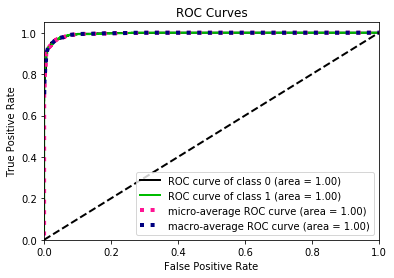

In [20]:
skplt.metrics.plot_roc_curve(test_y, y_predict_hard_prob)
plt.show()

In [21]:
confusion_matrix(test_y, y_predict_hard)

array([[1499,   61],
       [  48, 1542]])

In [22]:
print("Accuracy : ", accuracy_score(test_y, y_predict_hard))
print("Precision : ",precision_score(test_y, y_predict_hard))
print("Recall : ",recall_score(test_y, y_predict_hard))

print(classification_report(test_y, y_predict_hard, target_names=target_names))

('Accuracy : ', 0.9653968253968254)
('Precision : ', 0.9619463505926388)
('Recall : ', 0.969811320754717)
                       precision    recall  f1-score   support

  computer_technology       0.97      0.96      0.96      1560
recreational_activity       0.96      0.97      0.97      1590

          avg / total       0.97      0.97      0.97      3150



<h3> SVM Soft Margin Classifier</h3>
This is a soft margin classifier, which doesn't penalize the misclassified data points as much the hard margin classifier does. It tries to separate majority of the data points but doesn't focus on all the points thereby allowing few misclassified points. As it is more lenient than Hard Margin Classifier, we can see that the accuracy is only 50 percent. 

In [23]:
classifier_soft = svm.SVC(C=0.001, probability=True, kernel='linear')
classifier_soft.fit(train_x, train_y)

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_predict_soft = classifier_soft.predict(test_x)

In [25]:
y_predict_soft_prob = classifier_soft.predict_proba(test_x)

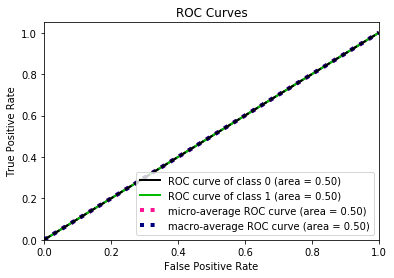

In [26]:
skplt.metrics.plot_roc_curve(test_y, y_predict_soft_prob)
plt.show()

In [27]:
confusion_matrix(test_y, y_predict_soft)

array([[   0, 1560],
       [   0, 1590]])

In [28]:
print("Accuracy : ", accuracy_score(test_y, y_predict_soft))
print("Precision : ",precision_score(test_y, y_predict_soft))
print("Recall : ",recall_score(test_y, y_predict_soft))

print(classification_report(test_y, y_predict_soft, target_names=target_names))

('Accuracy : ', 0.5047619047619047)
('Precision : ', 0.5047619047619047)
('Recall : ', 1.0)
                       precision    recall  f1-score   support

  computer_technology       0.00      0.00      0.00      1560
recreational_activity       0.50      1.00      0.67      1590

          avg / total       0.25      0.50      0.34      3150



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h3> Finding the best value of Gamma</h3>
To find the best value for Gamma we use GridSearch for different values along with 5-fold cross validation.

In [23]:
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

target_names = ["Computer Technology", "Recreational Activity"]

In [24]:
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=dict(C=gamma_values), cv=5)
grid.fit(train_x, train_y)
print(grid.best_score_)

0.9672442941673711


In [25]:
y_predict_best = grid.predict(test_x)
print(classification_report(test_y, y_predict_best, target_names=target_names))
print("Accuracy Score: " + str(accuracy_score(test_y, y_predict_best)))

                       precision    recall  f1-score   support

  Computer Technology       0.97      0.96      0.96      1560
Recreational Activity       0.96      0.97      0.97      1590

          avg / total       0.97      0.97      0.97      3150

Accuracy Score: 0.9653968253968254


In [56]:
confusion_matrix(test_y, y_predict_best)

array([[1470,   90],
       [  50, 1540]])

<h3> Multinomial Naive Bayes</h3>

In [32]:
classifier_NB = MultinomialNB().fit(train_x, train_y)

In [33]:
y_predict_nb = classifier_NB.predict(test_x)

In [34]:
y_predict_nb_prob = classifier_NB.predict_proba(test_x)

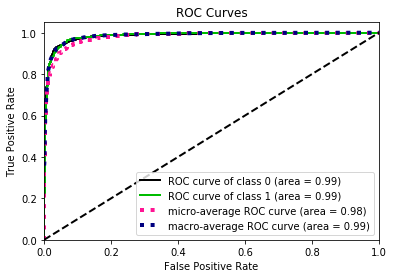

In [35]:
skplt.metrics.plot_roc_curve(test_y, y_predict_nb_prob)
plt.show()

In [36]:
confusion_matrix(test_y, y_predict_nb)

array([[1373,  187],
       [  32, 1558]])

In [37]:
print("Accuracy : ", accuracy_score(test_y, y_predict_nb))
print("Precision : ",precision_score(test_y, y_predict_nb))
print("Recall : ",recall_score(test_y, y_predict_nb))

print(classification_report(test_y, y_predict_nb, target_names=target_names))

('Accuracy : ', 0.9304761904761905)
('Precision : ', 0.8928366762177651)
('Recall : ', 0.979874213836478)
                       precision    recall  f1-score   support

  Computer Technology       0.98      0.88      0.93      1560
Recreational Activity       0.89      0.98      0.93      1590

          avg / total       0.93      0.93      0.93      3150



<h3>Logistic Regression without regularization</h3>

In [38]:
logistic_clf = LogisticRegression(penalty='l2', C=1e10)
logistic_clf.fit(train_x, train_y)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

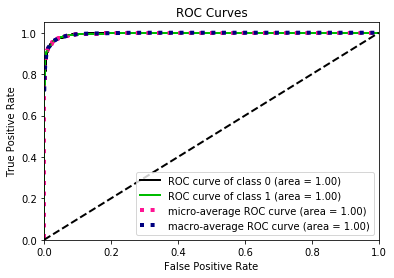

In [39]:
y_predict = logistic_clf.predict(test_x)
y_predict_prob = logistic_clf.predict_proba(test_x)
skplt.metrics.plot_roc_curve(test_y, y_predict_prob)
plt.show()

In [40]:
confusion_matrix(test_y, y_predict)

array([[1501,   59],
       [  52, 1538]])

In [41]:
print("Accuracy : ", accuracy_score(test_y, y_predict))
print("Precision : ",precision_score(test_y, y_predict))
print("Recall : ",recall_score(test_y, y_predict))

print(classification_report(test_y, y_predict, target_names=target_names))

('Accuracy : ', 0.9647619047619047)
('Precision : ', 0.963055729492799)
('Recall : ', 0.9672955974842767)
                       precision    recall  f1-score   support

  Computer Technology       0.97      0.96      0.96      1560
Recreational Activity       0.96      0.97      0.97      1590

          avg / total       0.96      0.96      0.96      3150



<h3>Logistic Regression with L2 regularization</h3>

In [42]:
logistic_clf = LogisticRegression(penalty='l2', C=1000)
logistic_clf.fit(train_x, train_y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
y_predict = logistic_clf.predict(test_x)

y_predict_prob = logistic_clf.predict_proba(test_x)

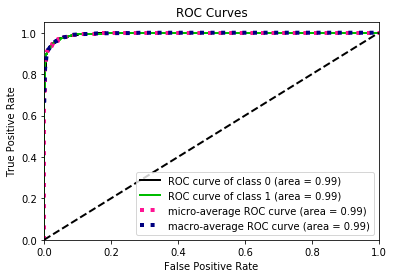

In [44]:
skplt.metrics.plot_roc_curve(test_y, y_predict_prob)
plt.show()

In [45]:
confusion_matrix(test_y, y_predict)

array([[1486,   74],
       [  50, 1540]])

In [46]:
print("Accuracy : ", accuracy_score(test_y, y_predict))
print("Precision : ",precision_score(test_y, y_predict))
print("Recall : ",recall_score(test_y, y_predict))

print(classification_report(test_y, y_predict, target_names=target_names))

('Accuracy : ', 0.9606349206349206)
('Precision : ', 0.9541511771995044)
('Recall : ', 0.9685534591194969)
                       precision    recall  f1-score   support

  Computer Technology       0.97      0.95      0.96      1560
Recreational Activity       0.95      0.97      0.96      1590

          avg / total       0.96      0.96      0.96      3150



<h3>Logistic Regression with L1 regularization</h3>

In [47]:
logistic_clf = LogisticRegression(penalty='l1', C=1000)
logistic_clf.fit(train_x, train_y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
y_predict = logistic_clf.predict(test_x)

y_predict_prob = logistic_clf.predict_proba(test_x)

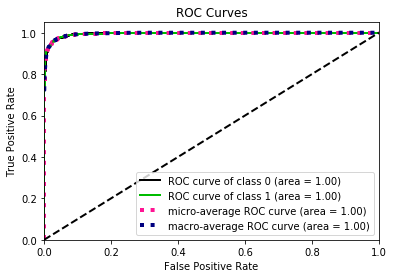

In [49]:
skplt.metrics.plot_roc_curve(test_y, y_predict_prob)
plt.show()

In [50]:
confusion_matrix(test_y, y_predict)

array([[1501,   59],
       [  52, 1538]])

In [51]:
print("Accuracy : ", accuracy_score(test_y, y_predict))
print("Precision : ",precision_score(test_y, y_predict))
print("Recall : ",recall_score(test_y, y_predict))

print(classification_report(test_y, y_predict, target_names=target_names))

('Accuracy : ', 0.9647619047619047)
('Precision : ', 0.963055729492799)
('Recall : ', 0.9672955974842767)
                       precision    recall  f1-score   support

  Computer Technology       0.97      0.96      0.96      1560
Recreational Activity       0.96      0.97      0.97      1590

          avg / total       0.96      0.96      0.96      3150

